The goal of this notebook is to construct linear state observers based on the models generated by each model reduction method

In [36]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da

import opinf


config = dotenv_values(".env")
from util import *

In [37]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/threeSegmentData200Timesteps/"
# Read in system and gain matrices from .mat file
systemMats = scipy.io.loadmat(filepath + "romSystemMatricesAndGains_12dim_5train_25test.mat")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
L_era = systemMats["L_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
L_dmdc = systemMats["L_dmdc"]
# Opinf Matrices
A_opInf = systemMats["A_opInf"]
B_opInf = systemMats["B_opInf"]
C_opInf = systemMats["C_opInf"]
L_opInf = systemMats["L_opInf"]
# LOpInf Matrices
A_lopInf = systemMats["A_lopinf"]
B_lopInf = systemMats["B_lopinf"]
C_lopInf = systemMats["C_lopinf"]
D_lopInf = systemMats["D_lopinf"]
L_lopInf = systemMats["L_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

In [38]:
# Read in basis transformations for methods that enable state reconstruction
lopinfOperators = scipy.io.loadmat(filepath + "lopinf_rom_r_6_operators.mat")
basis_dmdc = systemMats["basis_dmdc"]
basis_lopinf = lopinfOperators["V"]
# Pad the lopinf basis with columns of 0s so that it has 12 columns
basis_lopinf = np.hstack((basis_lopinf, np.zeros((basis_lopinf.shape[0], 12 - basis_lopinf.shape[1]))))
# Convert to dask arrays
basis_dmdc = da.from_array(basis_dmdc, chunks=(basis_dmdc.shape[0], basis_dmdc.shape[1]))
basis_lopinf = da.from_array(basis_lopinf, chunks=(basis_lopinf.shape[0], basis_lopinf.shape[1]))



# Observer Comparison Experiments

In [39]:
# Load in data
data = np.load(filepath + "processedDataSet.npz",mmap_mode='r')
# Read in a trial
trial = 0
# Read in the data for the specific trial
Y_fom = data["reducedCenterlineData"][:,:,trial]
Y0 = data["reducedCenterlineData"][:,0,trial]
Y_fom[:,:] = Y_fom[:,:] - Y0[:].reshape(-1,1)
U_fom = data["inputData"][:,:,trial]
timesteps = Y_fom.shape[1]
# Save state data to so we can memmap it later
# np.save(filepath + "temp/stateData.npy", data["stateData"])
# Extract simulation parameters
numTrials = data["reducedCenterlineData"].shape[2]



In [40]:
# Initialize observer state and output for each ROM method
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps)) # Closed loop era observer
x_hat_ol_era = np.zeros((A_era.shape[0], timesteps)) # Open loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps)) # Closed loop era observer
y_hat_ol_era = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer
# DMDc
x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps)) # Closed loop dmdc observer
x_hat_ol_dmdc = np.zeros((A_dmdc.shape[0], timesteps)) # Open loop dmdc observer
y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps)) # Closed loop dmdc observer
y_hat_ol_dmdc = np.zeros((C_dmdc.shape[0], timesteps)) # Open loop dmdc observer
# Opinf
x_hat_opInf = np.zeros((A_opInf.shape[0], timesteps)) # Closed loop opinf observer
x_hat_ol_opInf = np.zeros((A_opInf.shape[0], timesteps)) # Open loop opinf observer
y_hat_opInf = np.zeros((C_opInf.shape[0], timesteps)) # Closed loop opinf observer
y_hat_ol_opInf = np.zeros((C_opInf.shape[0], timesteps)) # Open loop opinf observer
# LOpinf
x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps)) # Closed loop lopinf observer
x_hat_ol_lopInf = np.zeros((A_lopInf.shape[0], timesteps)) # Open loop lopinf observer
y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps)) # Closed loop lopinf observer
y_hat_ol_lopInf = np.zeros((C_lopInf.shape[0], timesteps)) # Open loop lopinf observer



# Iterate through each timestep applying observer update law
for i in range(timesteps-1):
    # Update observer states
    x_hat_era[:,i+1] = A_era @ x_hat_era[:,i] +B_era@U_fom[:,i] - L_era @ (y_hat_era[:,i] - Y_fom[:,i]) # Closed loop era observer
    x_hat_ol_era[:,i+1] = A_era @ x_hat_ol_era[:,i] +B_era@U_fom[:,i] # Open loop era observer
    x_hat_dmdc[:,i+1] = A_dmdc @ x_hat_dmdc[:,i] +B_dmdc@U_fom[:,i] - L_dmdc @ (y_hat_dmdc[:,i] - Y_fom[:,i]) # Closed loop dmdc observer
    x_hat_ol_dmdc[:,i+1] = A_dmdc @ x_hat_ol_dmdc[:,i] +B_dmdc@U_fom[:,i] # Open loop dmdc observer
    x_hat_opInf[:,i+1] = A_opInf @ x_hat_opInf[:,i] +B_opInf@U_fom[:,i] - L_opInf @ (y_hat_opInf[:,i] - Y_fom[:,i]) # Closed loop opinf observer
    x_hat_ol_opInf[:,i+1] = A_opInf @ x_hat_ol_opInf[:,i] +B_opInf@U_fom[:,i] # Open loop opinf observer
    x_hat_lopInf[:,i+1] = A_lopInf @ x_hat_lopInf[:,i] +B_lopInf@U_fom[:,i] - L_lopInf @ (y_hat_lopInf[:,i] - Y_fom[:,i]) # Closed loop lopinf observer
    x_hat_ol_lopInf[:,i+1] = A_lopInf @ x_hat_ol_lopInf[:,i] +B_lopInf@U_fom[:,i] # Open loop lopinf observer


    # Update observer output
    y_hat_era[:,i+1] = C_era @ x_hat_era[:,i+1] + D_era @ U_fom[:,i] # Closed loop era observer
    y_hat_ol_era[:,i+1] = C_era @ x_hat_ol_era[:,i+1] + D_era @ U_fom[:,i] # Open loop era observer
    y_hat_dmdc[:,i+1] = C_dmdc @ x_hat_dmdc[:,i+1]  # Closed loop dmdc observer
    y_hat_ol_dmdc[:,i+1] = C_dmdc @ x_hat_ol_dmdc[:,i+1]  # Open loop dmdc observer
    y_hat_opInf[:,i+1] = C_opInf @ x_hat_opInf[:,i+1] # Closed loop opinf observer
    y_hat_ol_opInf[:,i+1] = C_opInf @ x_hat_ol_opInf[:,i+1] # Open loop opinf observer
    y_hat_lopInf[:,i+1] = C_lopInf @ x_hat_lopInf[:,i+1] # Closed loop lopinf observer
    y_hat_ol_lopInf[:,i+1] = C_lopInf @ x_hat_ol_lopInf[:,i+1] # Open loop lopinf observer
    




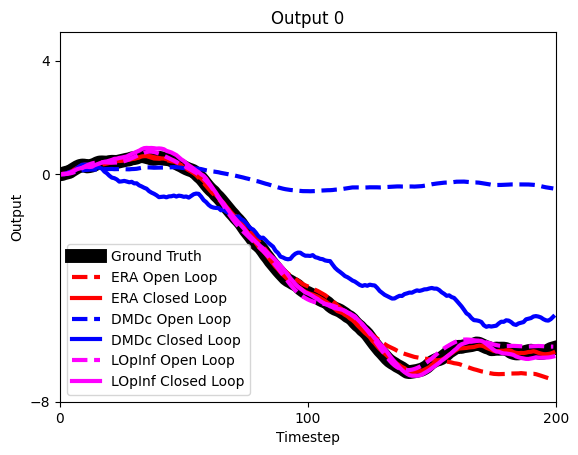

In [41]:
# plot first output from observer against ground truth with open loop responses in dashed lines and closed loop responses in solid lines
plt.plot(Y_fom[0,:], label="Ground Truth", color="black", linewidth=10)
plt.plot(y_hat_ol_era[0,:], "--", label="ERA Open Loop", color="red", linewidth=3)
plt.plot(y_hat_era[0,:], label="ERA Closed Loop", color="red", linewidth=3)
plt.plot(y_hat_ol_dmdc[0,:], "--", label="DMDc Open Loop", color="blue", linewidth=3)
plt.plot(y_hat_dmdc[0,:], label="DMDc Closed Loop", color="blue", linewidth=3)
# plt.plot(y_hat_ol_opInf[0,:], "--", label="OpInf Open Loop", linewidth=5)
# plt.plot(y_hat_opInf[0,:], label="OpInf Closed Loop", linewidth=5)
plt.plot(y_hat_ol_lopInf[0,:], "--", label="LOpInf Open Loop", color="magenta", linewidth=3)
plt.plot(y_hat_lopInf[0,:], label="LOpInf Closed Loop", color="magenta", linewidth=3)
plt.xlabel("Timestep")
plt.ylabel("Output")
plt.title("Output 0")
plt.xlim([0, 200])
plt.ylim([-8, 5])
plt.xticks([0, 100, 200])
plt.yticks([-8, 0, 4])

plt.legend()
# plt.show()
# Save as svg
plt.savefig("output0Trial1.pdf", format="pdf")


In [42]:
# Generate open and closed loop responses for each observer for every trial
# FOM
Y_fom = data["reducedCenterlineData"][:,:,:]
U_fom = data["inputData"][:,:,:]
# subtract initial condition from Y_fom for each trial
for i in range(Y_fom.shape[2]):
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y_fom[:,0,i].reshape(-1,1)

# Initialize arrays to store data
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps, numTrials)) # Closed loop era observer
x_hat_ol_era = np.zeros((A_era.shape[0], timesteps, numTrials)) # Open loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps, numTrials)) # Closed loop era observer
y_hat_ol_era = np.zeros((C_era.shape[0], timesteps, numTrials)) # Open loop era observer
# DMDc
x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps, numTrials)) # Closed loop dmdc observer
x_hat_ol_dmdc = np.zeros((A_dmdc.shape[0], timesteps, numTrials)) # Open loop dmdc observer
y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps, numTrials)) # Closed loop dmdc observer
y_hat_ol_dmdc = np.zeros((C_dmdc.shape[0], timesteps, numTrials)) # Open loop dmdc observer
# Opinf
x_hat_opInf = np.zeros((A_opInf.shape[0], timesteps, numTrials)) # Closed loop opinf observer
x_hat_ol_opInf = np.zeros((A_opInf.shape[0], timesteps, numTrials)) # Open loop opinf observer
y_hat_opInf = np.zeros((C_opInf.shape[0], timesteps, numTrials)) # Closed loop opinf observer
y_hat_ol_opInf = np.zeros((C_opInf.shape[0], timesteps, numTrials)) # Open loop opinf observer
# LOpinf
x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps, numTrials)) # Closed loop lopinf observer
x_hat_ol_lopInf = np.zeros((A_lopInf.shape[0], timesteps, numTrials)) # Open loop lopinf observer  
y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps, numTrials)) # Closed loop lopinf observer
y_hat_ol_lopInf = np.zeros((C_lopInf.shape[0], timesteps, numTrials)) # Open loop lopinf observer

# Iterate through each trial
for trial in range(numTrials):
    # Iterate through each timestep applying observer update law
    for i in range(timesteps-1):
        # Update observer states
        x_hat_era[:,i+1,trial] = A_era @ x_hat_era[:,i,trial] +B_era@U_fom[:,i,trial] - L_era @ (y_hat_era[:,i,trial] - Y_fom[:,i,trial]) # Closed loop era observer
        x_hat_ol_era[:,i+1,trial] = A_era @ x_hat_ol_era[:,i,trial] +B_era@U_fom[:,i,trial] # Open loop era observer
        x_hat_dmdc[:,i+1,trial] = A_dmdc @ x_hat_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] - L_dmdc @ (y_hat_dmdc[:,i,trial] - Y_fom[:,i,trial]) # Closed loop dmdc observer
        x_hat_ol_dmdc[:,i+1,trial] = A_dmdc @ x_hat_ol_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] # Open loop dmdc observer
        x_hat_opInf[:,i+1,trial] = A_opInf @ x_hat_opInf[:,i,trial] +B_opInf@U_fom[:,i,trial] - L_opInf @ (y_hat_opInf[:,i,trial] - Y_fom[:,i,trial]) # Closed loop opinf observer
        x_hat_ol_opInf[:,i+1,trial] = A_opInf @ x_hat_ol_opInf[:,i,trial] +B_opInf@U_fom[:,i,trial] # Open loop opinf observer
        x_hat_lopInf[:,i+1,trial] = A_lopInf @ x_hat_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] - L_lopInf @ (y_hat_lopInf[:,i,trial] - Y_fom[:,i,trial]) # Closed loop lopinf observer
        x_hat_ol_lopInf[:,i+1,trial] = A_lopInf @ x_hat_ol_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] # Open loop lopinf observer

        # Update observer output
        y_hat_era[:,i+1,trial] = C_era @ x_hat_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Closed loop era observer
        y_hat_ol_era[:,i+1,trial] = C_era @ x_hat_ol_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Open loop era observer
        y_hat_dmdc[:,i+1,trial] = C_dmdc @ x_hat_dmdc[:,i+1,trial] # Closed loop dmdc observer
        y_hat_ol_dmdc[:,i+1,trial] = C_dmdc @ x_hat_ol_dmdc[:,i+1,trial]  # Open loop dmdc observer
        y_hat_opInf[:,i+1,trial] = C_opInf @ x_hat_opInf[:,i+1,trial] # Closed loop opinf observer
        y_hat_ol_opInf[:,i+1,trial] = C_opInf @ x_hat_ol_opInf[:,i+1,trial] # Open loop opinf observer
        y_hat_lopInf[:,i+1,trial] = C_lopInf @ x_hat_lopInf[:,i+1,trial] # Closed loop lopinf observer
        y_hat_ol_lopInf[:,i+1,trial] = C_lopInf @ x_hat_ol_lopInf[:,i+1,trial] # Open loop lopinf observer
        

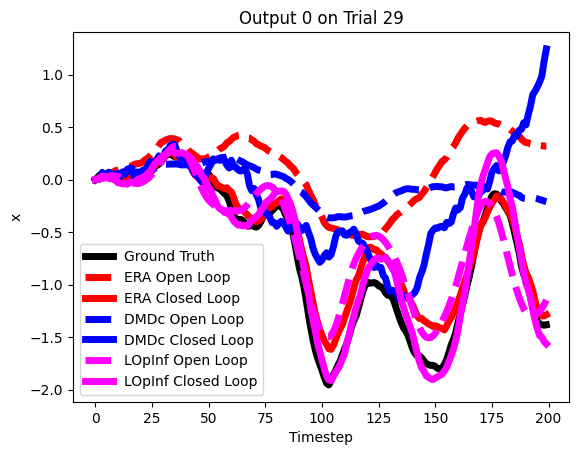

In [43]:
# Plot results for a specific trial with open loop responses in dashed lines and closed loop responses in solid lines and ground truth in black

trial = 29
fig, ax = plt.subplots()


# plt.figure()
ax.plot(Y_fom[0,:,trial], label="Ground Truth", color="black", linewidth=5)
ax.plot(y_hat_ol_era[0,:,trial], "--", label="ERA Open Loop", color="red", linewidth=5)
ax.plot(y_hat_era[0,:,trial], label="ERA Closed Loop", color="red", linewidth=5)
ax.plot(y_hat_ol_dmdc[0,:,trial], "--", label="DMDc Open Loop", color="blue", linewidth=5)
ax.plot(y_hat_dmdc[0,:,trial], label="DMDc Closed Loop", color="blue", linewidth=5)
# plt.plot(y_hat_ol_opInf[0,:,trial], "--", label="OpInf Open Loop", color="green", linewidth=5)
# plt.plot(y_hat_opInf[0,:,trial], label="OpInf Closed Loop", color="green", linewidth=5)
ax.plot(y_hat_ol_lopInf[0,:,trial], "--", label="LOpInf Open Loop", color="magenta", linewidth=5)
ax.plot(y_hat_lopInf[0,:,trial], label="LOpInf Closed Loop", color="magenta", linewidth=5)
ax.set_xlabel("Timestep")
ax.set_ylabel("x")
ax.set_title("Output 0 on Trial " + str(trial))
ax.legend()
# Save as svg
plt.savefig("output0_trial" + str(trial) + ".pdf", format="pdf")

In [44]:
# Convert everything to dask arrays
A_era = da.from_array(A_era, chunks=(A_era.shape[0], A_era.shape[1]))
B_era = da.from_array(B_era, chunks=(B_era.shape[0], B_era.shape[1]))
C_era = da.from_array(C_era, chunks=(C_era.shape[0], C_era.shape[1]))
D_era = da.from_array(D_era, chunks=(D_era.shape[0], D_era.shape[1]))
L_era = da.from_array(L_era, chunks=(L_era.shape[0], L_era.shape[1]))
A_dmdc = da.from_array(A_dmdc, chunks=(A_dmdc.shape[0], A_dmdc.shape[1]))
B_dmdc = da.from_array(B_dmdc, chunks=(B_dmdc.shape[0], B_dmdc.shape[1]))
C_dmdc = da.from_array(C_dmdc, chunks=(C_dmdc.shape[0], C_dmdc.shape[1]))
L_dmdc = da.from_array(L_dmdc, chunks=(L_dmdc.shape[0], L_dmdc.shape[1]))
A_opInf = da.from_array(A_opInf, chunks=(A_opInf.shape[0], A_opInf.shape[1]))
B_opInf = da.from_array(B_opInf, chunks=(B_opInf.shape[0], B_opInf.shape[1]))
C_opInf = da.from_array(C_opInf, chunks=(C_opInf.shape[0], C_opInf.shape[1]))
L_opInf = da.from_array(L_opInf, chunks=(L_opInf.shape[0], L_opInf.shape[1]))
A_lopInf = da.from_array(A_lopInf, chunks=(A_lopInf.shape[0], A_lopInf.shape[1]))
B_lopInf = da.from_array(B_lopInf, chunks=(B_lopInf.shape[0], B_lopInf.shape[1]))
C_lopInf = da.from_array(C_lopInf, chunks=(C_lopInf.shape[0], C_lopInf.shape[1]))
D_lopInf = da.from_array(D_lopInf, chunks=(D_lopInf.shape[0], D_lopInf.shape[1]))
L_lopInf = da.from_array(L_lopInf, chunks=(L_lopInf.shape[0], L_lopInf.shape[1]))
x0 = da.from_array(x0, chunks=(x0.shape[0], x0.shape[1]))
Y_fom = da.from_array(Y_fom, chunks=(Y_fom.shape[0], Y_fom.shape[1], Y_fom.shape[2]))
U_fom = da.from_array(U_fom, chunks=(U_fom.shape[0], U_fom.shape[1], U_fom.shape[2]))

# Convert all rom state arrays to dask arrays
x_hat_era = da.from_array(x_hat_era, chunks=(x_hat_era.shape[0], x_hat_era.shape[1], x_hat_era.shape[2]))
x_hat_ol_era = da.from_array(x_hat_ol_era, chunks=(x_hat_ol_era.shape[0], x_hat_ol_era.shape[1], x_hat_ol_era.shape[2]))
y_hat_era = da.from_array(y_hat_era, chunks=(y_hat_era.shape[0], y_hat_era.shape[1], y_hat_era.shape[2]))
y_hat_ol_era = da.from_array(y_hat_ol_era, chunks=(y_hat_ol_era.shape[0], y_hat_ol_era.shape[1], y_hat_ol_era.shape[2]))
x_hat_dmdc = da.from_array(x_hat_dmdc, chunks=(x_hat_dmdc.shape[0], x_hat_dmdc.shape[1], x_hat_dmdc.shape[2]))
x_hat_ol_dmdc = da.from_array(x_hat_ol_dmdc, chunks=(x_hat_ol_dmdc.shape[0], x_hat_ol_dmdc.shape[1], x_hat_ol_dmdc.shape[2]))
y_hat_dmdc = da.from_array(y_hat_dmdc, chunks=(y_hat_dmdc.shape[0], y_hat_dmdc.shape[1], y_hat_dmdc.shape[2]))
y_hat_ol_dmdc = da.from_array(y_hat_ol_dmdc, chunks=(y_hat_ol_dmdc.shape[0], y_hat_ol_dmdc.shape[1], y_hat_ol_dmdc.shape[2]))
x_hat_opInf = da.from_array(x_hat_opInf, chunks=(x_hat_opInf.shape[0], x_hat_opInf.shape[1], x_hat_opInf.shape[2]))
x_hat_ol_opInf = da.from_array(x_hat_ol_opInf, chunks=(x_hat_ol_opInf.shape[0], x_hat_ol_opInf.shape[1], x_hat_ol_opInf.shape[2]))
y_hat_opInf = da.from_array(y_hat_opInf, chunks=(y_hat_opInf.shape[0], y_hat_opInf.shape[1], y_hat_opInf.shape[2]))
y_hat_ol_opInf = da.from_array(y_hat_ol_opInf, chunks=(y_hat_ol_opInf.shape[0], y_hat_ol_opInf.shape[1], y_hat_ol_opInf.shape[2]))
x_hat_lopInf = da.from_array(x_hat_lopInf, chunks=(x_hat_lopInf.shape[0], x_hat_lopInf.shape[1], x_hat_lopInf.shape[2]))
x_hat_ol_lopInf = da.from_array(x_hat_ol_lopInf, chunks=(x_hat_ol_lopInf.shape[0], x_hat_ol_lopInf.shape[1], x_hat_ol_lopInf.shape[2]))
y_hat_lopInf = da.from_array(y_hat_lopInf, chunks=(y_hat_lopInf.shape[0], y_hat_lopInf.shape[1], y_hat_lopInf.shape[2]))
y_hat_ol_lopInf = da.from_array(y_hat_ol_lopInf, chunks=(y_hat_ol_lopInf.shape[0], y_hat_ol_lopInf.shape[1], y_hat_ol_lopInf.shape[2]))



In [45]:
# Compute open and closed loop RMS output errors for each method in each trial
# Initialize arrays to store open loop and closed loop RMS errors
rms_era = da.zeros((2, numTrials)) # ERA
rms_dmdc = da.zeros((2, numTrials)) # DMDc
rms_opInf = da.zeros((2, numTrials)) # OpInf
rms_lopInf = da.zeros((2, numTrials)) # LOpInf
# Iterate through each trial
for trial in range(numTrials):
    # Compute open loop RMS error
    rms_era[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_era[:,:,trial])))
    rms_dmdc[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_dmdc[:,:,trial])))
    rms_opInf[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_opInf[:,:,trial])))
    rms_lopInf[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_lopInf[:,:,trial])))
    # Compute closed loop RMS error
    rms_era[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_era[:,:,trial])))
    rms_dmdc[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_dmdc[:,:,trial])))
    rms_opInf[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_opInf[:,:,trial])))
    rms_lopInf[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_lopInf[:,:,trial])))


In [46]:
# Execute dask arrays
rms_era = rms_era.compute()
rms_dmdc = rms_dmdc.compute()
rms_opInf = rms_opInf.compute()
rms_lopInf = rms_lopInf.compute()

In [47]:
# Make table of mean +/- standard deviation, max, and min of RMS errors for each method
# Initialize table
rms_table = PrettyTable()
rms_table.field_names = ["Method", "Mean +/- Std Dev", "Max", "Min"]
# Add rows to table
rms_table.add_row(["ERA Open Loop", str(np.mean(rms_era[0,:])) + " +/- " + str(np.std(rms_era[0,:])), str(np.max(rms_era[0,:])) + " in trial " + str(np.argmax(rms_era[0,:])), str(np.min(rms_era[0,:])) + " in trial " + str(np.argmin(rms_era[0,:]))])
rms_table.add_row(["ERA Closed Loop", str(np.mean(rms_era[1,:])) + " +/- " + str(np.std(rms_era[1,:])), str(np.max(rms_era[1,:])) + " in trial " + str(np.argmax(rms_era[1,:])), str(np.min(rms_era[1,:])) + " in trial " + str(np.argmin(rms_era[1,:]))])
rms_table.add_row(["DMDc Open Loop", str(np.mean(rms_dmdc[0,:])) + " +/- " + str(np.std(rms_dmdc[0,:])), str(np.max(rms_dmdc[0,:])) + " in trial " + str(np.argmax(rms_dmdc[0,:])), str(np.min(rms_dmdc[0,:])) + " in trial " + str(np.argmin(rms_dmdc[0,:]))])
rms_table.add_row(["DMDc Closed Loop", str(np.mean(rms_dmdc[1,:])) + " +/- " + str(np.std(rms_dmdc[1,:])), str(np.max(rms_dmdc[1,:])) + " in trial " + str(np.argmax(rms_dmdc[1,:])), str(np.min(rms_dmdc[1,:])) + " in trial " + str(np.argmin(rms_dmdc[1,:]))])
rms_table.add_row(["OpInf Open Loop", str(np.mean(rms_opInf[0,:])) + " +/- " + str(np.std(rms_opInf[0,:])), str(np.max(rms_opInf[0,:])) + " in trial " + str(np.argmax(rms_opInf[0,:])), str(np.min(rms_opInf[0,:])) + " in trial " + str(np.argmin(rms_opInf[0,:]))])
rms_table.add_row(["OpInf Closed Loop", str(np.mean(rms_opInf[1,:])) + " +/- " + str(np.std(rms_opInf[1,:])), str(np.max(rms_opInf[1,:])) + " in trial " + str(np.argmax(rms_opInf[1,:])), str(np.min(rms_opInf[1,:])) + " in trial " + str(np.argmin(rms_opInf[1,:]))])
rms_table.add_row(["LOpInf Open Loop", str(np.mean(rms_lopInf[0,:])) + " +/- " + str(np.std(rms_lopInf[0,:])), str(np.max(rms_lopInf[0,:])) + " in trial " + str(np.argmax(rms_lopInf[0,:])), str(np.min(rms_lopInf[0,:])) + " in trial " + str(np.argmin(rms_lopInf[0,:]))])
rms_table.add_row(["LOpInf Closed Loop", str(np.mean(rms_lopInf[1,:])) + " +/- " + str(np.std(rms_lopInf[1,:])), str(np.max(rms_lopInf[1,:])) + " in trial " + str(np.argmax(rms_lopInf[1,:])), str(np.min(rms_lopInf[1,:])) + " in trial " + str(np.argmin(rms_lopInf[1,:]))])
# Print table
print(rms_table)



+--------------------+--------------------------------------------+--------------------------------+--------------------------------+
|       Method       |              Mean +/- Std Dev              |              Max               |              Min               |
+--------------------+--------------------------------------------+--------------------------------+--------------------------------+
|   ERA Open Loop    | 1.3758165643457958 +/- 0.6393856901846369  | 2.7082137446804806 in trial 28 | 0.4544315427048303 in trial 0  |
|  ERA Closed Loop   | 0.5603951367273681 +/- 0.2882709730925698  | 1.5037395908905946 in trial 9  | 0.13641058796908795 in trial 0 |
|   DMDc Open Loop   | 1.7302231188221349 +/- 0.7795673578446122  |  4.079808208996158 in trial 0  | 0.7843133031501588 in trial 29 |
|  DMDc Closed Loop  | 1.3298134654197822 +/- 0.5974138392392659  |  3.255255509276381 in trial 0  | 0.5374202529951797 in trial 21 |
|  OpInf Open Loop   |                nan +/- nan             

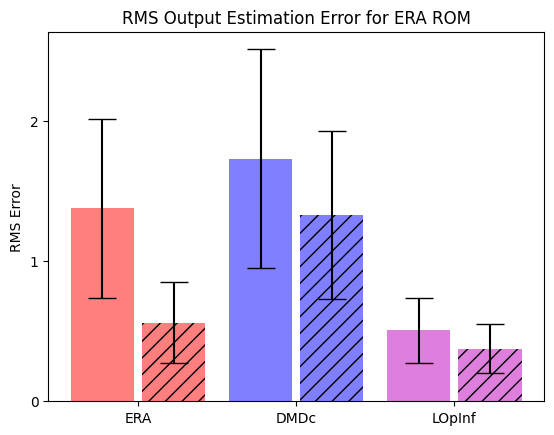

In [48]:
# Bar plot with error bars of open loop and closed loop RMS output errors for each method where open loop and closed loop responses are adjacent
fig, ax = plt.subplots()

ax.bar(np.arange(0,6,2)-0.45, [np.mean(rms_era[0,:]), np.mean(rms_dmdc[0,:]), np.mean(rms_lopInf[0,:])], yerr=[np.std(rms_era[0,:]), np.std(rms_dmdc[0,:]), np.std(rms_lopInf[0,:])], color=['r','b','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,6,2)+0.45, [np.mean(rms_era[1,:]), np.mean(rms_dmdc[1,:]), np.mean(rms_lopInf[1,:])], yerr=[np.std(rms_era[1,:]), np.std(rms_dmdc[1,:]), np.std(rms_lopInf[1,:])], color=['r','b','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
# # Plot max and min of each method overlayed on bars
# ax.plot(np.arange(0,6,2)-0.45, [np.max(rms_era[0,:]), np.max(rms_dmdc[0,:]), np.max(rms_lopInf[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)-0.45, [np.min(rms_era[0,:]), np.min(rms_dmdc[0,:]), np.min(rms_lopInf[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)+0.45, [np.max(rms_era[1,:]), np.max(rms_dmdc[1,:]), np.max(rms_lopInf[1,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)+0.45, [np.min(rms_era[1,:]), np.min(rms_dmdc[1,:]), np.min(rms_lopInf[1,:])], 'k_', markersize=10, markeredgewidth=3)



ax.set_xticks(np.arange(0,6,2))
ax.set_xticklabels(['ERA','DMDc','LOpInf'])
ax.set_yticks([0,1,2])


ax.set_ylabel("RMS Error")
ax.set_title("RMS Output Estimation Error for ERA ROM")
# TODO: Fix legend

# Set legend where solid box is open loop and hatched box is closed loop
# ax.legend(['Max','Min','Open Loop','Closed Loop'],loc='upper left')

# Save as svg
plt.savefig('RMSOutputEstimation.pdf', format='pdf', dpi=1200)

In [49]:
# Reconstruct full order states for DMDc and LOpInf using the basis transformations for every trial in the open and closed loop cases
# Initialize arrays to store reconstructed states
# DMDc
x_hat_dmdc_full = da.zeros((basis_dmdc.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))
x_hat_ol_dmdc_full = da.zeros((basis_dmdc.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))
# LOpinf
x_hat_lopInf_full = da.zeros((basis_lopinf.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))
x_hat_ol_lopInf_full = da.zeros((basis_lopinf.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))

# For each timestep of each trial, reconstruct the full order state using the basis transformation
for trial in range(numTrials):
    x_hat_dmdc_full[:,:,trial] = basis_dmdc @ x_hat_dmdc[:,:,trial]
    x_hat_ol_dmdc_full[:,:,trial] = basis_dmdc @ x_hat_ol_dmdc[:,:,trial]
    x_hat_lopInf_full[:,:,trial] = basis_lopinf @ x_hat_lopInf[:,:,trial]
    x_hat_ol_lopInf_full[:,:,trial] = basis_lopinf @ x_hat_ol_lopInf[:,:,trial]

In [50]:
# del data

In [51]:
# Read in full state data from memmaped file as dask array
stateData = da.from_array(data['stateData'], chunks=(10000, timesteps, 1))
# Center state data for each trial
for trial in range(numTrials):
    stateData[:,:,trial] = stateData[:,:,trial] - stateData[:,0,trial].reshape(-1,1)

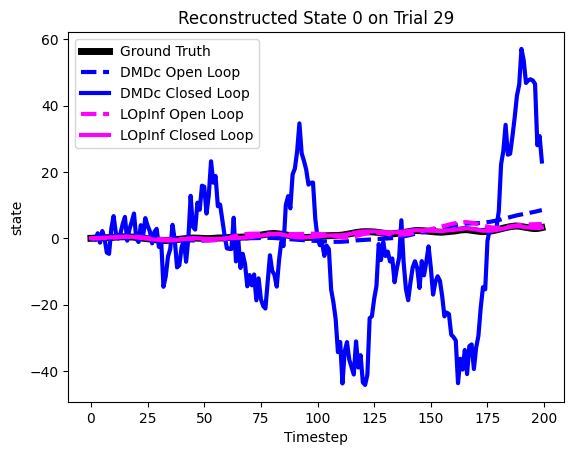

In [52]:
# Plot results for a specific trial with open loop responses in dashed lines and closed loop responses in solid lines and ground truth in black
trial = 29
plt.figure()
plt.plot(stateData[0,:,trial].compute()-stateData[0,0,trial].compute(), label="Ground Truth", color="black", linewidth=5)
plt.plot(x_hat_ol_dmdc_full[0,:,trial].compute(), "--", label="DMDc Open Loop", color="blue", linewidth=3)
plt.plot(x_hat_dmdc_full[0,:,trial].compute(), label="DMDc Closed Loop", color="blue", linewidth=3)
plt.plot(x_hat_ol_lopInf_full[0,:,trial].compute(), "--", label="LOpInf Open Loop", color="magenta", linewidth=3)
plt.plot(x_hat_lopInf_full[0,:,trial].compute(), label="LOpInf Closed Loop", color="magenta", linewidth=3)
plt.xlabel("Timestep")
plt.ylabel("state")
plt.title("Reconstructed State 0 on Trial " + str(trial))
plt.legend()
# plt.show()



In [53]:
# Compute open and closed loop RMS state errors for each method in each trial
# Initialize arrays to store open loop and closed loop RMS errors
rms_dmdc_full = da.zeros((2, numTrials)) # DMDc
rms_lopInf_full = da.zeros((2, numTrials)) # LOpInf
# Iterate through each trial
for trial in range(numTrials):
    # Compute open loop RMS error
    rms_dmdc_full[0,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_ol_dmdc_full[:,:,trial])))
    rms_lopInf_full[0,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_ol_lopInf_full[:,:,trial])))
    # Compute closed loop RMS error
    rms_dmdc_full[1,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_dmdc_full[:,:,trial])))
    rms_lopInf_full[1,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_lopInf_full[:,:,trial])))


In [54]:
# Execute dask arrays 
rms_dmdc_full = rms_dmdc_full.compute()
rms_lopInf_full = rms_lopInf_full.compute()


In [55]:
# Make table of mean +/- standard deviation, max, and min of RMS errors for each method
# Initialize table
rms_table = PrettyTable()
rms_table.field_names = ["Method", "Mean +/- Std Dev", "Max", "Min"]
# Add rows to table
rms_table.add_row(["DMDc Open Loop", str(np.mean(rms_dmdc_full[0,:])) + " +/- " + str(np.std(rms_dmdc_full[0,:])), str(np.max(rms_dmdc_full[0,:])) + " in trial " + str(np.argmax(rms_dmdc_full[0,:])), str(np.min(rms_dmdc_full[0,:])) + " in trial " + str(np.argmin(rms_dmdc_full[0,:]))])
rms_table.add_row(["DMDc Closed Loop", str(np.mean(rms_dmdc_full[1,:])) + " +/- " + str(np.std(rms_dmdc_full[1,:])), str(np.max(rms_dmdc_full[1,:])) + " in trial " + str(np.argmax(rms_dmdc_full[1,:])), str(np.min(rms_dmdc_full[1,:])) + " in trial " + str(np.argmin(rms_dmdc_full[1,:]))])
rms_table.add_row(["LOpInf Open Loop", str(np.mean(rms_lopInf_full[0,:])) + " +/- " + str(np.std(rms_lopInf_full[0,:])), str(np.max(rms_lopInf_full[0,:])) + " in trial " + str(np.argmax(rms_lopInf_full[0,:])), str(np.min(rms_lopInf_full[0,:])) + " in trial " + str(np.argmin(rms_lopInf_full[0,:]))])
rms_table.add_row(["LOpInf Closed Loop", str(np.mean(rms_lopInf_full[1,:])) + " +/- " + str(np.std(rms_lopInf_full[1,:])), str(np.max(rms_lopInf_full[1,:])) + " in trial " + str(np.argmax(rms_lopInf_full[1,:])), str(np.min(rms_lopInf_full[1,:])) + " in trial " + str(np.argmin(rms_lopInf_full[1,:]))])
# Print table
print(rms_table)

+--------------------+--------------------------------------------+-------------------------------+---------------------------------+
|       Method       |              Mean +/- Std Dev              |              Max              |               Min               |
+--------------------+--------------------------------------------+-------------------------------+---------------------------------+
|   DMDc Open Loop   | 0.8991124339924464 +/- 0.35246759705613995 | 2.057825082433075 in trial 21 | 0.39484897508960465 in trial 11 |
|  DMDc Closed Loop  |  35.9327452694976 +/- 17.768978387586813   |  78.17312965900298 in trial 0 |  14.331516745518297 in trial 21 |
|  LOpInf Open Loop  | 0.273587601466111 +/- 0.10929475946249788  |  0.557335410222301 in trial 6 |  0.15100011395632704 in trial 4 |
| LOpInf Closed Loop | 0.2786940839737442 +/- 0.12333183658526399 | 0.6238427854228795 in trial 6 |  0.1513964301882248 in trial 4  |
+--------------------+----------------------------------------

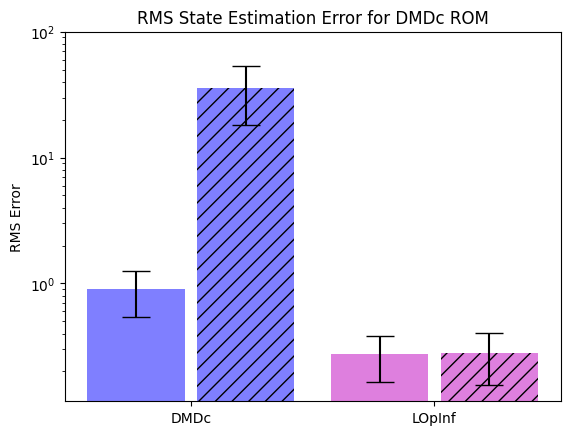

In [56]:
# Bar plot with error bars of open loop and closed loop RMS state errors for each method where open loop and closed loop responses are adjacent
fig, ax = plt.subplots()

# ax.figure(figsize=(10,5))
ax.bar(np.arange(0,4,2)-0.45, [np.mean(rms_dmdc_full[0,:]), np.mean(rms_lopInf_full[0,:])], yerr=[np.std(rms_dmdc_full[0,:]), np.std(rms_lopInf_full[0,:])], color=['b','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,4,2)+0.45, [np.mean(rms_dmdc_full[1,:]), np.mean(rms_lopInf_full[1,:])], yerr=[np.std(rms_dmdc_full[1,:]), np.std(rms_lopInf_full[1,:])], color=['b','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')

# Plot max and min of each method overlayed on bars
# ax.plot(np.arange(0,4,2)-0.45, [np.max(rms_dmdc_full[0,:]), np.max(rms_lopInf_full[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)-0.45, [np.min(rms_dmdc_full[0,:]), np.min(rms_lopInf_full[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)+0.45, [np.max(rms_dmdc_full[1,:]), np.max(rms_lopInf_full[1,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)+0.45, [np.min(rms_dmdc_full[1,:]), np.min(rms_lopInf_full[1,:])], 'k_', markersize=10, markeredgewidth=3)

# Change to log scale y axis
ax.set_yscale('log')

ax.set_xticks(np.arange(0,4,2))
ax.set_xticklabels(['DMDc','LOpInf'])
ax.set_yticks([1e0,1e1,1e2])



ax.set_ylabel("RMS Error")
ax.set_title("RMS State Estimation Error for DMDc ROM")
# Make legend where hatched boxes correspond to closed loop responses and solid boxes correspond to open loop responses

# Save as svg
plt.savefig('stateObserverAnalysis.pdf', format='pdf', dpi=1200)
